In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
import pickle
import gensim
import time
import os

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel


Populating the interactive namespace from numpy and matplotlib


/apps/software/standard/core/anaconda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
unable to import 'smart_open.gcs', disabling that module


In [3]:
#Change to your data folder appropriately
os.chdir('/home/sc2pg/src/prnd/publicrd/data/prd/RND Topic Modelling') 

In [4]:
#Data load
c_lda=pd.read_pickle('Final_Models/NSF/lda_NSF_coherence.pkl')
p_lda=pd.read_pickle('Final_Models/NSF/lda_NSF_perplexity.pkl')
c_lsa=pd.read_pickle('nsf_lsa_c.pkl')
c_nmf=pd.read_pickle('nmf_NSF_coherence.pkl')

#At a column n_topic for ease of filtering. Sometimes filtering on index is a pain.
c_lda['n_topics']=c_lda.index
c_lsa['n_topics']=c_lsa.index
p_lda['n_topics']=p_lda.index
c_nmf['n_topics']=c_nmf.index

In [5]:
#Change to your graphics folder appropriately
os.chdir('/home/sc2pg/src/prnd/publicrd/graphics') 

In [6]:
#Used for slide comparing different models.
for i in [c_lda,c_lsa,c_nmf]:
    mini=i.loc[44]
    print('Mean')
    print(np.mean(mini))
    print('Standard Deviation')
    print(np.std(mini))

0.5899353383780701
0.008762557135889196
0.35708850507875034
0.004593045652681543
0.6945414920628732
0.0027040366094062316


In [13]:
#How the model numbers of LDA 52 and NMF 44 were chosen:

for model_to_test,label in zip([p_lda,c_lda,c_nmf],['Perplexity LDA','Coherence LDA','Coherence NMF']):
    #For each of these models, I chose the point where the coherence was no longer monotonically increasing (coherence)--perplexity is added in for reference
    #44 for NMF, 52 for LDA
    std=model_to_test.drop(['n_topics'],axis=1).apply(np.std,axis=1)
    mu=model_to_test.drop(['n_topics'],axis=1).apply(np.mean,axis=1)
    print(label)
    new_df=pd.concat([mu,std],axis=1)
    new_df.columns=['Topic Mean','Standard Deviation']
    display(new_df)

Perplexity LDA


,Topic Mean,Standard Deviation
4,2674.979401,45.890786
8,2342.740788,24.323522
12,2232.424910,20.473860
16,2149.903161,12.552976
20,2096.859412,10.568710
24,2058.709200,9.151672
28,2040.338381,10.706827
32,2013.715845,10.704416
36,2006.796180,7.509665
40,1996.462922,9.495305


Coherence LDA


,Topic Mean,Standard Deviation
4,0.465107,0.016986
8,0.527575,0.017326
12,0.534507,0.009700
16,0.556796,0.009536
20,0.566546,0.010575
24,0.578839,0.008157
28,0.579110,0.010495
32,0.588605,0.005770
36,0.587552,0.010561
40,0.589719,0.010373


Coherence NMF


,Topic Mean,Standard Deviation
4,0.579119,1.110223e-16
8,0.643339,1.110223e-16
12,0.674333,3.181780e-03
16,0.679624,1.820877e-03
20,0.680897,3.741797e-03
24,0.680100,3.524451e-03
28,0.687080,4.330406e-03
32,0.692203,1.671082e-03
36,0.692468,2.712221e-03
40,0.693632,2.955151e-03


In [16]:
#tidy format for ease of plotting
c_lsa_melt=c_lsa.melt(id_vars='n_topics',value_vars=['iteration {}'.format(i) for i in range(10)],value_name='Coherence' )
c_nmf_melt=c_nmf.melt(id_vars='n_topics',value_vars=['iteration {}'.format(i) for i in range(10)],value_name='Coherence' )

c_lda_melt=c_lda.melt(id_vars='n_topics',value_vars=['iteration {}'.format(i) for i in range(10)],value_name='Coherence' )
p_lda_melt=p_lda.melt(id_vars='n_topics',value_vars=['iteration {}'.format(i) for i in range(10)],value_name='Perplexity' )

c_lsa_melt['Model_Type']='LSA'
c_lda_melt['Model_Type']='LDA'
c_nmf_melt['Model_Type']='NMF'


all_models=pd.concat([c_lsa_melt,c_lda_melt,c_nmf_melt])

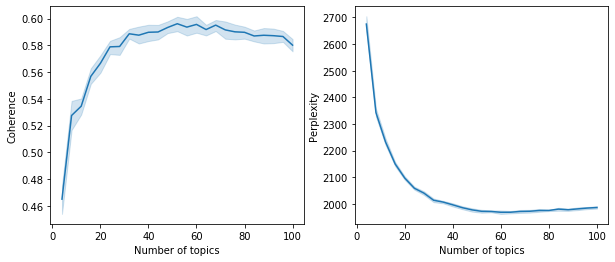

In [15]:
#Show the similarity in where the metrics plateau for both metrics for LDA
fig,ax=plt.subplots(1,2, figsize=[10,4],sharex=True)
sns.lineplot(x="n_topics", y="Coherence", data=c_lda_melt,ax=ax[0])
plt.sca(ax[0])
plt.xlabel('Number of topics')
sns.lineplot(x="n_topics", y="Perplexity", data=p_lda_melt,ax=ax[1])
plt.sca(ax[1])
plt.xlabel('Number of topics')
plt.savefig('ldaperformanceperplexityandcoherenceovertopics10runs.png',bbox_inches='tight',dpi=900)

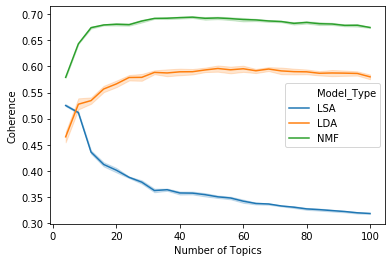

In [17]:
#Overall performance of every model tested at every 4th topic number for 4 to 100.
sns.lineplot(x="n_topics", y="Coherence", hue='Model_Type', data=all_models)
plt.xlabel('Number of Topics')
plt.savefig('Coherence3modelsoverNtopics.png',dpi=900,bbox_inches='tight')

In [ ]:
############33
#Now that the model topic numbers and respective iterations of those topic numbers have been chosen, generate a pickle of the chosen models
#This code is taken directly from NumTopicsTune, but has been updated to only run once, on a single topic number based on above, to compare the top 30 topic- terms of each
##############

In [21]:
# import NSF data
os.chdir('/home/sc2pg/src/prnd/publicrd/data/prd/RND Topic Modelling') 
f = open('nsf_stanford_lemma.sav', 'rb')

# import entire dataset
#f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/RND Topic Modelling/lda_data_stanford_lemma.sav', 'rb')

[corpus, id2word, docs] = pickle.load(f)
f.close()


text = []
for doc in docs:
    text.append(" ".join(doc))

In [22]:

def list_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        #print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

def generate_run_dataframe(lda_model, vectorizer, top_n=10, model_number=-1):
    norm=lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
    new_series=[['Word {}'.format(i) for i in range(top_n)]]
    labels=['Word']
    labels.extend(['Topic {}'.format(y) for y in range(len(norm))])
    for idx, topic in enumerate(norm):  # loop through each row of H.  idx = row index.  topic = actual row
        #print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], '{0:.4f}'.format(topic[i]))  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        new_series.append(print_list)
    if model_number!=-1:
        new_series.append([model_number]*top_n)
        labels.append('Model Run')
    return pd.DataFrame(new_series,index=labels).T

def model_run_generation_comparison(doc_term_matrix,n_runs, topic_numbers,top_n_words, vectorizer, corpus, id2word, docs):
    for num_topics in topic_numbers:
        model_outputs=[]
        print('Num Topic: {}'.format(num_topics))
        for i in range(n_runs):
            print(i)
            # create model
            nmf_model = NMF(n_components=num_topics, random_state = i*scaling_factor)
            nmf_model.fit_transform(doc_term_matrix)
            model_outputs.append(generate_run_dataframe(nmf_model,vectorizer, top_n=top_n_words,model_number=i))

        pd.concat(model_outputs,ignore_index=True).to_csv('10RunsModelNSF{}topics.csv'.format(num_topics))

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.4, min_df=3, lowercase=False, max_features=int(len(docs)/2))
tf_idf = tfidf_vectorizer.fit_transform(text)

In [30]:
#Generates model run comparison documents
topic_VOIs=[32,44]
scaling_factor=len(range(4,101,4))
num_runs=10
model_run_generation_comparison(tf_idf,n_runs=10,topic_numbers=topic_VOIs,top_n_words=30,vectorizer=tfidf_vectorizer,
                               corpus=corpus, id2word=id2word,docs=docs)

Num Topic: 32
0
1
2
3
4
5
6
7
8
9
Num Topic: 44
0
1
2
3
4
5
6
7
8
9


In [27]:
c_nmf.loc[44] #This was the chosen topic numbe, and iteration 4 was used as the model since it had the highest coherence. I also considered 32 based on the graph, but 44 was interpetable
#And this decision criteria made it easy to generalize across models

iteration 0     0.692153
iteration 1     0.693112
iteration 2     0.695555
iteration 3     0.694630
iteration 4     0.700055
iteration 5     0.694256
iteration 6     0.697693
iteration 7     0.690430
iteration 8     0.695471
iteration 9     0.692061
n_topics       44.000000
Name: 44, dtype: float64

In [ ]:
scaling_factor=range(4,101,4)

####################
#Calculate NMF
#################
        
def nmf_model_generation(doc_term_matrix, n_topics, rand_start):
        # create model
        nmf_model = NMF(n_components=n_topics, random_state = rand_start)
        nmf_model.fit_transform(doc_term_matrix)
        
        print('Number of topics =', num_topics, "complete.")

    return nmf_model        
        

chosen_iteration=4
chosen_topic_n=44
    
# run models
nmf_model = nmf_model_generation(doc_term_matrix=tf_idf, n_topics=chosen_topic_n, rand_start = chosen_iteration*scaling_factor)

#Can be merged with nsf_stanford_lemma to create a final dataset
nmf_model.to_pickle('./Final_Models/NMFChosenModelpkl.pkl')

# create list of topics
topics = list_topics(nmf_model, tfidf_vectorizer, top_n=10)

# calculate coherence
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                    coherence='c_v', processes=20) #window_size=500 ) 
coherence = cm.get_coherence() 
co_by_topic = cm.get_coherence_per_topic(with_std=True)
print(co_by_topic)

In [ ]:
scaling_factor=range(4,101,4)

chosen_iteration=3
chosen_topic_n=52

def lda_model_generation(doc_term_matrix, topic_number,top_n_words, vectorizer, corpus, id2word, docs,chosen_iteration):
        #Create model
        lda_model = LatentDirichletAllocation(n_components=topic_number, doc_topic_prior = 1/topic_number,
                                              topic_word_prior=0.1, n_jobs=39, random_state = chosen_iteration*scaling_factor)
        lda_model.fit_transform(doc_term_matrix)

    return lda_model

topic_VOIs=[52]
lda_model=lda_model_generation(doc_term_matrix,topic_number=chosen_topic_n,top_n_words=30,vectorizer=vectorizer,
                               corpus=corpus, id2word=id2word,docs=docs,chosen_iteration=3)
filehandler = open('./Final_Models/TLDA52model.pkl',"wb")
pickle.dump(lda_model,filehandler)
filehandler.close()

topics = list_topics(lda_model, vectorizer, top_n=10)

# calculate coherence
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                    coherence='c_v', processes=20) #window_size=500 ) 
coherence = cm.get_coherence() 
co_by_topic = cm.get_coherence_per_topic(with_std=True)
print(co_by_topic)